In [1]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

# Sea Surface Altimetry Data Analysis

This example uses gridded sea-surface altimetry data from The Copernicus Marine Environment:

http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047

This is a widely used dataset in physical oceanography and climate.

![globe image](http://marine.copernicus.eu/documents/IMG/SEALEVEL_GLO_SLA_MAP_L4_REP_OBSERVATIONS_008_027.png)

The dataset has already been extracted from copernicus and stored in google cloud storage in [xarray-zarr](http://xarray.pydata.org/en/latest/io.html#zarr) format.

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gcsfs
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline

### Initialize Dataset

Here we load the dataset from the zarr store. Note that this very large dataset initializes nearly instantly, and we can see the full list of variables and coordinates.

In [3]:
gcsmap = gcsfs.mapping.GCSMap('pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt')
ds = xr.open_zarr(gcsmap)
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<shape=(8901, 720, 2), chunksize=(5, 720, 2)>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
    lon_bnds   (longitude, nv) float32 dask.array<shape=(1440, 2), chunksize=(1440, 2)>
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    err        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    sla        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    ugos       (time, latitude, longitude) float64 dask.array<shape=(8901,

In [4]:
for v in ds.data_vars:
    print('{:>10}: {}'.format(v, ds[v].attrs['long_name']))

       adt: Absolute dynamic topography
       err: Formal mapping error
       sla: Sea level anomaly
      ugos: Absolute geostrophic velocity: zonal component
     ugosa: Geostrophic velocity anomalies: zonal component
      vgos: Absolute geostrophic velocity: meridian component
     vgosa: Geostrophic velocity anomalies: meridian component


### **Create and Connect to Dask Distributed Cluster**

In [5]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=20)
cluster

In [7]:
client = Client(cluster)
client

Client Scheduler: tcp://10.40.201.51:41469 Dashboard: /user/rogema/proxy/8787/status,Cluster Workers: 14 Cores: 28 Memory: 98.00 GB


### **Computation of EKE**

### Function to compute the temporal mean EKE from a dataset containing the geostrophic speed anomalies

In [8]:
def EKE(ds):
    EKE = ((ds.ugosa - ds.ugosa.mean(dim='time')) ** 2 + (ds.vgosa - ds.vgosa.mean(dim='time')) ** 2).mean(dim='time')
    return EKE

### Apply this function by months on the AVISO dataset 

In [9]:
eke_monthly = ds.groupby('time.month').apply(EKE)

### Computation

In [ ]:
EKE_by_month = eke_monthly.compute()

### Plot the mean EKE for June

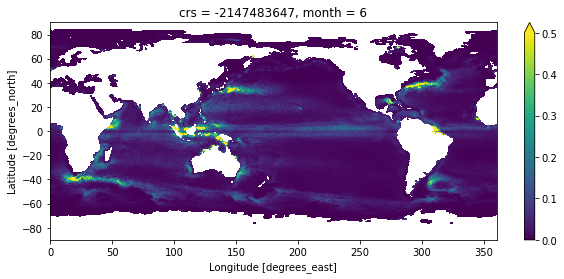

In [11]:
plt.figure(figsize=(10, 4))
EKE_by_month.sel(month=6).plot(vmin=0., vmax=0.5)

In [ ]:
EKE_by_month = EKE_by_month.rename('EKE')

### Store the new dataset in a netcdf file

In [11]:
EKE_by_month.to_netcdf('EKE_by_month.nc')

### Get the monthly climatology of the absolute geostrophic velocities 

In [7]:
ugeos_monthly = ds.ugos.groupby('time.month').mean(dim='time').compute()
vgeos_monthly = ds.vgos.groupby('time.month').mean(dim='time').compute()

In [8]:
ugeos_monthly.to_netcdf('Ugeos_by_month.nc')
vgeos_monthly.to_netcdf('Vgeos_by_month.nc')
